# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import numpy as np

from numpy.matlib import repmat
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the ventilator and sEMG data

In [2]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()
base_path = config.get_directory('patient_data')
patient_paths = file_discovery.find_folders(
    base_path,
    folder_levels=['patient'])
patient = list(patient_paths['patient'].values)[0]

# Then find the files for the selected patients:
folder_levels = ['date', 'measurement']
patient_path = os.path.join(base_path, patient)

emg_files = file_discovery.find_files(
    base_path=patient_path,
    file_name_regex='EMG_recording',
    extension_regex='poly5',
    folder_levels=folder_levels)

folder_levels = ['date', 'measurement']
vent_files = file_discovery.find_files(
    base_path=patient_path,
    file_name_regex='Draeger_recording',
    extension_regex='poly5',
    folder_levels=folder_levels)

button_list = ipy_widgets.file_select(
    emg_files,
    folder_levels=folder_levels[:-1],
    default_value_select=None,
    default_idx_select=[1, 6])

These files did not match the provided depth:
 [['2021-12-27_09-16-26', '00_Incorrect', '006 - Vroegtijdig gestopt', 'EMG_recording.poly5'], ['2021-12-27_09-16-26', '00_Incorrect', '009 - PS ipv PEEP', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '001', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '002', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '003', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '004', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '005', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '006', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '007', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '008', 'EMG_recording.poly5']]
These files did not match the provided depth:
 [['2021-12-27_09-16-26', '00_Incorrect', '006 - Vroegtijdig gestopt', 'Draeger_recording.poly5'], ['2021-12-27_09-16-26', '00_Incorrect', '009 - PS ipv PEEP', 'Draeger_recording.poly5'], ['No_NMC', '2021-12-

interactive(children=(Dropdown(description='date:', options=('2021-12-24_09-29-46', '2021-12-27_09-16-26', '20…

In [3]:
# Load the EMG and ventilator data recordings from the selected folders.
emg_file_chosen = os.path.join(
    patient_path, *[btn.value for btn in button_list], 'EMG_recording.Poly5')
vent_file_chosen = os.path.join(
    patient_path, *[btn.value for btn in button_list], 'Draeger_recording.Poly5')

data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
fs_vent = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples[:, 1*fs_emg:61*fs_emg]
y_vent = data_vent_samples[:, 1*fs_vent:61*fs_vent]

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

Reading file  P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\005\EMG_recording.Poly5
	 Number of samples:  972944 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\005\Draeger_recording.Poly5
	 Number of samples:  47504 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [4]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi', 'EMGpara'],
    units=3*['uV'])

# Store the ventilator data in a group of TimeSeries objects
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=['Paw', 'F', 'Vvent'],
    units=['cmH2O', 'L/s', 'L'])


Auto-detected ECG channel from labels.
Auto-detected Pvent channel from labels.
Auto-detected Flow channel from labels.
Auto-detected Volume channel from labels.


- Bandpass hp_cf (2-80) lc 50 - 1000
- ECG elimination:
    - Gating: Filling methods
    - ICA: In vs out
    - Wavelet denoising
    - Template subtraction
- Envelope
    - RMS: Window 50 - 400 ms
    - ARV: Window 50 - 400 ms
- Baseline crossing detection
    - Graßhoff: Baseline percentile (20, 33, 40)
    - CoV baseline (Warnaar 2024)
    - Slopesum baseline
    - Slope extrapolation
- Features:
    - ETP
    - Max to baseline
    - Risetime

# 3. Band-pass filtering

In [5]:
x_lim = 10.0
y_lim = 10.0

In [6]:
# # Iterate over filtering order

# # Side plot
# fig = plt.figure(layout="constrained", figsize=(8, 6))

# gs = GridSpec(3, 2, figure=fig)
# axes_emg = fig.add_subplot(gs[:, 1])
# for i in range(3):
#     ax = fig.add_subplot(gs[i, 0], sharex=axes_emg)
# axis = np.array(fig.axes)
# axes_vent = axis[-3:]


# # EMG data
# # - Bandpass lc (2-80) hc 50 - 1000
# orders = [1, 2, 3, 4, 8]
# # hp_cfs = [2]
# colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
# # colors = ['tab:purple', 'tab:blue', 'tab:cyan', 'tab:olive', 'tab:green',
# #           'tab:red', 'tab:orange']

# for _, (order, color) in enumerate(zip(orders, colors)):
#     emg_timeseries[1].filter_emg(order=order)
#     emg_timeseries[1].gating(gate_width_samples=fs_emg//5, overwrite=True)
#     emg_timeseries[1].envelope()
#     emg_timeseries[1].plot_full(
#         axes=axes_emg,
#         signal_type='env',
#         baseline_bool=False,
#         colors=[color])
# # bbox_to_anchor=(0., -0.6, 1., -.6),
# axes_emg.legend(
#     [str(order) for order in orders], 
#     bbox_to_anchor=(0., 1.05, 1., 1.05),
#     loc='lower left',
#     ncols=5, 
#     mode="expand",
#     borderaxespad=0.)
# axes_emg.set_xlabel('t (s)')
# axes_emg.set_ylim([0, y_lim])

# # Ventilator data data
# # axes_vent = axis[:3]
# vent_timeseries.run('plot_full', axes=axes_vent)
# axes_vent[-1].set_xlabel('t (s)')

# # axis[-1, 0].axis('off')

# axes_vent[-1].set_xlim([0, x_lim])

(0.0, 10.0)

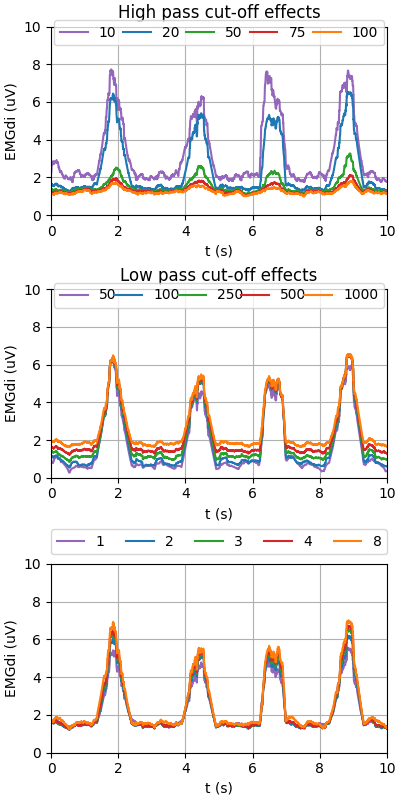

In [7]:
# Iterate over low- and high-pass cut-off frequency
fig = plt.figure(layout="constrained", figsize=(4, 8))

gs = GridSpec(6, 1, figure=fig)
axes_emg_2 = fig.add_subplot(gs[:2])
axes_emg_1 = fig.add_subplot(gs[2:4], sharex=axes_emg_2)
axes_emg_3 = fig.add_subplot(gs[4:], sharex=axes_emg_2)
# for i in range(3):
#     ax = fig.add_subplot(gs[i*2:i*2+2, 0], sharex=axes_emg_1)
# axis = np.array(fig.axes)
# axes_vent = axis[-3:]

# EMG data
# - Bandpass lc (2-80) hc 50 - 1000
lp_cfs = [50, 100, 250, 500, 1000]
# hp_cfs = [2]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
# colors = ['tab:purple', 'tab:blue', 'tab:cyan', 'tab:olive', 'tab:green',
#           'tab:red', 'tab:orange']

for _, (lp_cf, color) in enumerate(zip(lp_cfs, colors)):
    # emg_timeseries[1].filter_emg(lp_cf=lp_cf,  order=1)
    emg_timeseries[1].filter_emg(lp_cf=lp_cf)
    emg_timeseries[1].gating(
        gate_width_samples=fs_emg//5,
        overwrite=True,
    )
    emg_timeseries[1].envelope()
    emg_timeseries[1].plot_full(
        axes=axes_emg_1,
        signal_type='env',
        baseline_bool=False,
        colors=[color])
axes_emg_1.set_xlabel('t (s)')
axes_emg_1.set_ylim([0, y_lim])
axes_emg_1.set_title('Low pass cut-off effects')
axes_emg_1.legend(
    [str(lp_cf) for lp_cf in lp_cfs],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)


# - Bandpass lc (2-80) hc 50 - 1000
hp_cfs = [10, 20, 50, 75, 100]
# hp_cfs = [2]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
# colors = ['tab:purple', 'tab:blue', 'tab:cyan', 'tab:olive', 'tab:green',
#           'tab:red', 'tab:orange']

for _, (hp_cf, color) in enumerate(zip(hp_cfs, colors)):
    # emg_timeseries[1].filter_emg(hp_cf=hp_cf, order=1)
    emg_timeseries[1].filter_emg(hp_cf=hp_cf)
    emg_timeseries[1].gating(
        gate_width_samples=fs_emg//5,
        overwrite=True,
    )
    emg_timeseries[1].envelope()
    emg_timeseries[1].plot_full(
        axes=axes_emg_2,
        signal_type='env',
        baseline_bool=False,
        colors=[color])
axes_emg_2.set_xlabel('t (s)')
axes_emg_2.set_ylim([0, y_lim])
axes_emg_2.set_title('High pass cut-off effects')
axes_emg_2.legend(
    [str(hp_cf) for hp_cf in hp_cfs],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)


# - Bandpass lc (2-80) hc 50 - 1000
orders = [1, 2, 3, 4, 8]
# hp_cfs = [2]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
# colors = ['tab:purple', 'tab:blue', 'tab:cyan', 'tab:olive', 'tab:green',
#           'tab:red', 'tab:orange']

for _, (order, color) in enumerate(zip(orders, colors)):
    emg_timeseries[1].filter_emg(order=order)
    emg_timeseries[1].gating(gate_width_samples=fs_emg//5, overwrite=True)
    emg_timeseries[1].envelope()
    emg_timeseries[1].plot_full(
        axes=axes_emg_3,
        signal_type='env',
        baseline_bool=False,
        colors=[color])
# bbox_to_anchor=(0., -0.6, 1., -.6),
axes_emg_3.legend(
    [str(order) for order in orders], 
    bbox_to_anchor=(0., 1.05, 1., 1.05),
    loc='lower left',
    ncols=5, 
    mode="expand",
    borderaxespad=0.)
axes_emg_3.set_xlabel('t (s)')
axes_emg_3.set_ylim([0, y_lim])
axes_emg_3.set_xlabel('t (s)')
axes_emg_3.set_xlim([0, x_lim])

# # Ventilator data data
# vent_timeseries.plot_full(axes_vent)
# axis[-1].set_xlabel('t (s)')

# # axis[-1, 0].axis('off')

# axes_vent[-1].set_xlim([0, x_lim])

In [10]:
# Filter
emg_timeseries.run(
    'filter_emg',
    lp_cf=500,
    hp_cf=25,
    order=3,
)

# 4. ECG-removal

(0.0, 10.0)

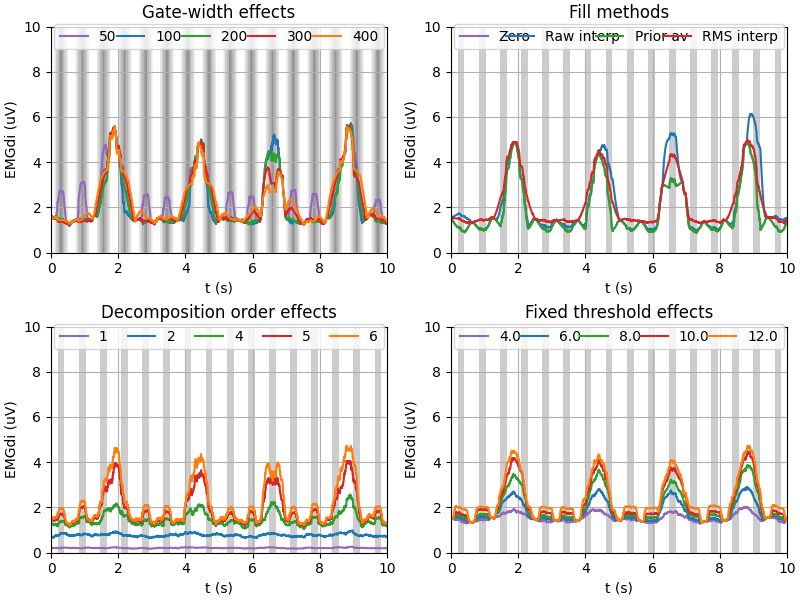

In [11]:
# Side plot
fig = plt.figure(layout="constrained", figsize=(8, 6))

gs = GridSpec(6, 2, figure=fig)
axes_emg_1 = fig.add_subplot(gs[:3, 0])
axes_emg_2 = fig.add_subplot(gs[:3, 1], sharex=axes_emg_1)
axes_emg_3 = fig.add_subplot(gs[3:, 0], sharex=axes_emg_1)
axes_emg_4 = fig.add_subplot(gs[3:, 1], sharex=axes_emg_1)
# for i in range(3):
#     ax = fig.add_subplot(gs[i*2:i*2+2, 0], sharex=axes_emg_1)
# axis = np.array(fig.axes)
# axes_vent = axis[-3:]

# EMG data
# ---- Gating ----
# Iterate over window length
gate_width_t_ms = [50, 100, 200, 300, 400]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
# gate_width_t_ms = [400]
# colors = ['tab:orange']
for _, (gate_width_t, color) in enumerate(zip(gate_width_t_ms, colors)):
    emg_timeseries[1].filter_emg(
        lp_cf=500,
        hp_cf=25,
        order=3,
    )
    gate_width_t_s = (gate_width_t *  fs_emg) // 1000
    emg_timeseries[1].gating(
        gate_width_samples=gate_width_t_s,
        fill_method=3,
        overwrite=True,)
    emg_timeseries[1].envelope()
    emg_timeseries[1].plot_full(
        axes=axes_emg_1,
        signal_type='env',
        baseline_bool=False,
        colors=[color])
axes_emg_1.set_xlabel('t (s)')
axes_emg_1.set_ylim([0, y_lim])
axes_emg_1.set_title('Gate-width effects')
axes_emg_1.legend(
    [str(gate_t) for gate_t in gate_width_t_ms],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

peak_idxs = emg_timeseries[1].peaks['ecg']['peak_idx']
peak_idxs = peak_idxs[peak_idxs < x_lim * fs_emg] - 10
t_emg_8 = np.array(t_emg)[np.array(t_emg) < x_lim * fs_emg]

t_to_peak = (np.min(np.abs(
    repmat(peak_idxs/fs_emg, len(t_emg_8), 1) 
    - repmat(t_emg_8, len(peak_idxs), 1).T), axis=1))
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (2.5 * 2),
                color='black', alpha=0.1, edgecolor=None)
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1*3 / (10 * 2),
                color='black', alpha=0.1, edgecolor=None)
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (5 * 2),
                color='black', alpha=0.1, edgecolor=None)
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (10 * 2),
                color='black', alpha=0.1, edgecolor=None)
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (20 * 2),
                color='black', alpha=0.1, edgecolor=None)


# Iterate over gating fill methods
methods = [0, 1, 2, 3]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red']
for _, (method, color) in enumerate(zip(methods, colors)):
    emg_timeseries[1].filter_emg(
        lp_cf=500,
        hp_cf=25,
        order=3,
    )
    # emg_timeseries[1].filter_emg(hp_cf=hp_cf, order=1)
    emg_timeseries[1].gating(
        fill_method=method,
        gate_width_samples=fs_emg//5,
        overwrite=True,
    )
    emg_timeseries[1].envelope(env_window=(fs_emg//5)*2)
    emg_timeseries[1].plot_full(
        axes=axes_emg_2,
        signal_type='env',
        baseline_bool=False,
        colors=[color])
axes_emg_2.set_xlabel('t (s)')
axes_emg_2.set_ylim([0, y_lim])
axes_emg_2.set_title('Fill methods')
methods_legend = ['Zero', 'Raw interp', 'Prior av', 'RMS interp']
axes_emg_2.legend(
    methods_legend,
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

axes_emg_2.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (5 * 2),
                color='black', alpha=0.2, edgecolor=None)


# ---- Wavelet denoising ----
# Iterate over order
orders = [1, 2, 4, 5, 6]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
# gate_width_t_ms = [400]
# colors = ['tab:orange']
for _, (order, color) in enumerate(zip(orders, colors)):
    emg_timeseries[1].filter_emg(
        lp_cf=500,
        hp_cf=25,
        order=3,
    )
    gate_width_t_s = (gate_width_t *  fs_emg) // 1000
    emg_timeseries[1].wavelet_denoising(
        n=order,
        fixed_threshold=10.0,
        overwrite=True,)
    emg_timeseries[1].envelope()
    emg_timeseries[1].plot_full(
        axes=axes_emg_3,
        signal_type='env',
        baseline_bool=False,
        colors=[color])
axes_emg_3.set_xlabel('t (s)')
axes_emg_3.set_ylim([0, y_lim])
axes_emg_3.set_title('Decomposition order effects')
axes_emg_3.legend(
    [str(n) for n in orders],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

peak_idxs = emg_timeseries[1].peaks['ecg']['peak_idx']
peak_idxs = peak_idxs[peak_idxs < x_lim * fs_emg] - 10
t_emg_8 = np.array(t_emg)[np.array(t_emg) < x_lim * fs_emg]

t_to_peak = (np.min(np.abs(
    repmat(peak_idxs/fs_emg, len(t_emg_8), 1) 
    - repmat(t_emg_8, len(peak_idxs), 1).T), axis=1))
axes_emg_3.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (5 * 2),
                color='black', alpha=0.2, edgecolor=None)


# Iterate over gating fill methods
fixed_thresholds = [4.0, 6.0, 8.0, 10.0, 12.0]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
for _, (fixed_threshold, color) in enumerate(zip(fixed_thresholds, colors)):
    emg_timeseries[1].filter_emg(
        lp_cf=500,
        hp_cf=25,
        order=3,
    )
    # emg_timeseries[1].filter_emg(hp_cf=hp_cf, order=1)
    emg_timeseries[1].wavelet_denoising(
        fixed_threshold=fixed_threshold,
        overwrite=True,)
    emg_timeseries[1].envelope(env_window=(fs_emg//5)*2)
    emg_timeseries[1].plot_full(
        axes=axes_emg_4,
        signal_type='env',
        baseline_bool=False,
        colors=[color])
axes_emg_4.set_xlabel('t (s)')
axes_emg_4.set_ylim([0, y_lim])
axes_emg_4.set_title('Fixed threshold effects')
axes_emg_4.legend(
    [str(threshold) for threshold in fixed_thresholds],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

axes_emg_4.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (5 * 2),
                        color='black', alpha=0.2, edgecolor=None)



axes_emg_1.set_xlim([0, x_lim])
# # Ventilator data data
# vent_timeseries.run('plot_full', axes=axes_vent)
# axis[-1].set_xlabel('t (s)')

# # axis[-1, 0].axis('off')

# axes_vent[-1].set_xlim([0, x_lim])

# 5. Envelope

In [12]:
# Gate the EMG
emg_timeseries.run(
    'filter_emg',
    lp_cf=500,
    hp_cf=25,
    order=3,
)
emg_timeseries.run('gating', gate_width_samples=fs_emg//5, overwrite=True)


Set ECG channel used for ECG removal.


(0.0, 10.0)

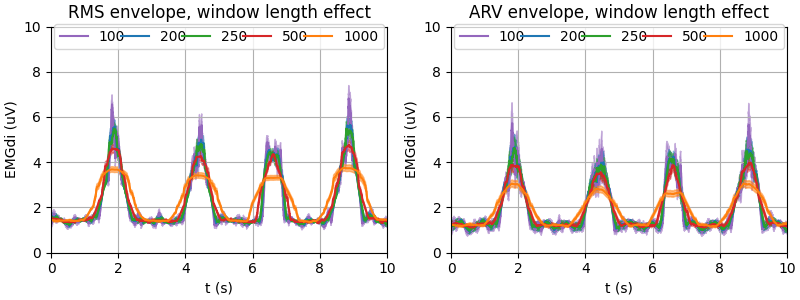

In [31]:
# Compare envelope methods

# Side plot
fig = plt.figure(layout="constrained", figsize=(8, 3))

gs = GridSpec(3, 2, figure=fig)
axes_emg_1 = fig.add_subplot(gs[:3, 0])
axes_emg_2 = fig.add_subplot(gs[:3, 1], sharex=axes_emg_1)
# for i in range(3):
#     ax = fig.add_subplot(gs[i*2:i*2+2, 0], sharex=axes_emg_1)
# axis = np.array(fig.axes)
# axes_vent = axis[-3:]

# EMG data
# RMS windows
rms_windows = [100, 200, 250, 500, 1000]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
for _, (rms_window, color) in enumerate(zip(rms_windows, colors)):
    emg_timeseries[1].envelope(
        env_type='rms', 
        env_window=(rms_window * fs_emg) // 1000,
        ci_alpha=0.05)
    emg_timeseries[1].plot_full(
        axes=axes_emg_1,
        signal_type='env',
        baseline_bool=False,
        colors=[color],
        plot_ci=True)
axes_emg_1.set_xlabel('t (s)')
axes_emg_1.set_ylim([0, y_lim])
axes_emg_1.set_title('RMS envelope, window length effect')
axes_emg_1.legend(
    axes_emg_1.lines[:],
    [str(rms_window) for rms_window in rms_windows],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)


# ARV windows
arv_windows = [100, 200, 250, 500, 1000]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
for _, (arv_window, color) in enumerate(zip(arv_windows, colors)):
    emg_timeseries[1].envelope(
        env_type='arv', 
        env_window=(arv_window * fs_emg) // 1000,
        ci_alpha=0.05)
    emg_timeseries[1].plot_full(
        axes=axes_emg_2,
        signal_type='env',
        baseline_bool=False,
        colors=[color],
        plot_ci=True)
axes_emg_2.set_xlabel('t (s)')
axes_emg_2.set_ylim([0, y_lim])
axes_emg_2.set_title('ARV envelope, window length effect')
axes_emg_2.legend(
    axes_emg_2.lines[:],
    [str(arv_window) for arv_window in arv_windows],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

axes_emg_1.set_xlim([0, x_lim])
# # Ventilator data data
# vent_timeseries.run('plot_full', axes=axes_vent)
# axis[-1].set_xlabel('t (s)')

# # axis[-1, 0].axis('off')

# axes_vent[-1].set_xlim([0, x_lim])

In [14]:
# Calculate the envelope of the signal
emg_timeseries.run('envelope', ci_alpha=0.05)

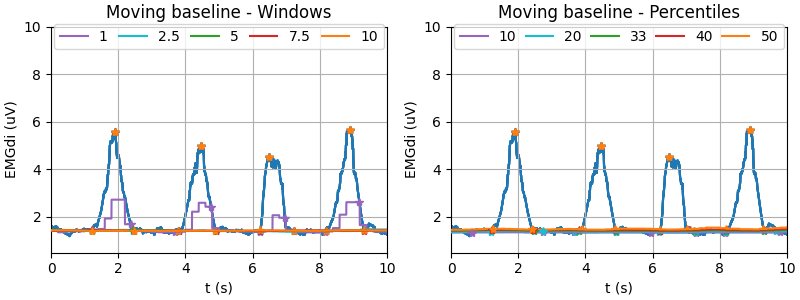

In [21]:
# Compare baseline methods - On- and offset detection

# Side plot
fig = plt.figure(layout="constrained", figsize=(8, 3))

gs = GridSpec(3, 2, figure=fig)
axes_emg_1 = fig.add_subplot(gs[:3, 0])
axes_emg_2 = fig.add_subplot(gs[:3, 1], sharex=axes_emg_1, sharey=axes_emg_1)
# for i in range(3):
#     ax = fig.add_subplot(gs[i*2:i*2+2, 0], sharex=axes_emg_1)
# axis = np.array(fig.axes)
# axes_vent = axis[-3:]

N_plots = 14

# EMG data
emg_di = emg_timeseries[1]
# Moving baseline - windows
bl_windows = [1, 2.5, 5, 7.5, 10]
colors = ['tab:purple', 'tab:cyan', 'tab:green', 'tab:red', 'tab:orange']
for _, (bl_window, color) in enumerate(zip(bl_windows, colors)):
    emg_timeseries[1].baseline(
        percentile=33,
        window_s=int(bl_window * fs_emg))
    emg_di.detect_emg_breaths(
        peak_set_name='breaths',
        end_idx = int(x_lim * fs_emg),
        prominence_factor = 1.5)
    emg_di.peaks['breaths'].detect_on_offset(
        baseline=emg_di.y_baseline
    )
    emg_timeseries[1].plot_full(
        axes=axes_emg_1,
        signal_type='env',
        baseline_bool=True,
        colors=['tab:blue', color])
    emg_di.plot_markers(peak_set_name='breaths', axes=axes_emg_1, colors=color)
axes_emg_1.set_xlabel('t (s)')
axes_emg_1.set_ylim([0.5, y_lim])
axes_emg_1.set_title('Moving baseline - Windows')
axes_emg_1.legend(
    [axes_emg_1.lines[i*N_plots+1] for i in range(len(bl_windows))],
    [str(bl_window) for bl_window in bl_windows],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

for line in [axes_emg_1.lines[i*N_plots] for i in range(len(bl_windows))]:
    line.set_zorder(0)

for line in [axes_emg_1.lines[i*N_plots+1] for i in range(len(bl_windows))]:
    line.set_zorder(5)

for line in [axes_emg_1.lines[i*N_plots+2] for i in range(len(bl_windows))]:
    line.set_zorder(10)

for line in [axes_emg_1.lines[i*N_plots+3] for i in range(len(bl_windows))]:
    line.set_zorder(10)

for line in [axes_emg_1.lines[i*N_plots+4] for i in range(len(bl_windows))]:
    line.set_zorder(10)

# Moving baseline - percentiles
bl_percentiles = [10, 20, 33, 40, 50]
colors = ['tab:purple', 'tab:cyan', 'tab:green', 'tab:red', 'tab:orange']
for _, (bl_percentile, color) in enumerate(zip(bl_percentiles, colors)):
    emg_timeseries.run(
        'baseline',
        percentile=bl_percentile,
        window_s=int(7.5 * fs_emg))
    emg_di.detect_emg_breaths(
        peak_set_name='breaths',
        end_idx = int(x_lim * fs_emg),
        prominence_factor=1.0)
    emg_di.peaks['breaths'].detect_on_offset(
        baseline=emg_di.y_baseline
    )
    emg_timeseries[1].plot_full(
        axes=axes_emg_2,
        signal_type='env',
        baseline_bool=True,
        colors=['tab:blue', color])
    emg_di.plot_markers(peak_set_name='breaths', axes=axes_emg_2, colors=color)
axes_emg_2.set_xlabel('t (s)')
axes_emg_2.set_ylim([0.5, y_lim])
axes_emg_2.set_title('Moving baseline - Percentiles')
axes_emg_2.legend(
    [axes_emg_2.lines[i*N_plots+1] for i in range(len(bl_percentiles))],
    [str(bl_percentile) for bl_percentile in bl_percentiles],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

axes_emg_2.set_xlim([0, x_lim])
# # Ventilator data data
# vent_timeseries.run('plot_full', axes=axes_vent)
# axis[-1].set_xlabel('t (s)')

for line in [axes_emg_2.lines[i*N_plots] for i in range(len(bl_percentiles))]:
    line.set_zorder(0)

for line in [axes_emg_2.lines[i*N_plots+1] for i in range(len(bl_percentiles))]:
    line.set_zorder(5)

for line in [axes_emg_2.lines[i*N_plots+2] for i in range(len(bl_percentiles))]:
    line.set_zorder(10)

for line in [axes_emg_2.lines[i*N_plots+3] for i in range(len(bl_percentiles))]:
    line.set_zorder(10)

for line in [axes_emg_2.lines[i*N_plots+4] for i in range(len(bl_percentiles))]:
    line.set_zorder(10)
# axis[-1, 0].axis('off')

# axes_vent[-1].set_xlim([0, x_lim])

In [16]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.run('baseline')
emg_di.detect_emg_breaths(
        peak_set_name='breaths',
        end_idx = int(x_lim * fs_emg),
        prominence_factor=1.0)
emg_di.peaks['breaths'].detect_on_offset(
    baseline=emg_di.y_baseline
)

In [17]:
# Find supported breath pressures
vent_timeseries[0].baseline(
    signal_type='raw',
    percentile=50)
vent_timeseries[2].baseline(
    signal_type='raw',
    percentile=33)

p_vent = vent_timeseries.channels[vent_timeseries.p_vent_idx]
v_vent = vent_timeseries.channels[vent_timeseries.v_vent_idx]
vent_timeseries.find_tidal_volume_peaks(
    start_idx=0,
    end_idx=int(x_lim*fs_emg),
)
p_vent.peaks['ventilator_breaths'].detect_on_offset(
    baseline=p_vent.y_baseline)
v_vent.peaks['ventilator_breaths'].detect_on_offset(
    baseline=v_vent.y_baseline)

In [18]:
# Find the EMG peaks with the peak timing closest to the Pocc timings, and
# link ventilator Pocc peaks to EMG breaths
t_breaths_peaks_vent = p_vent.peaks['ventilator_breaths']['peak_idx'] / p_vent.param['fs']

emg_di.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_breaths_peaks_vent,
    linked_peak_set_name='breaths_linked',
)

(0.0, 10.0)

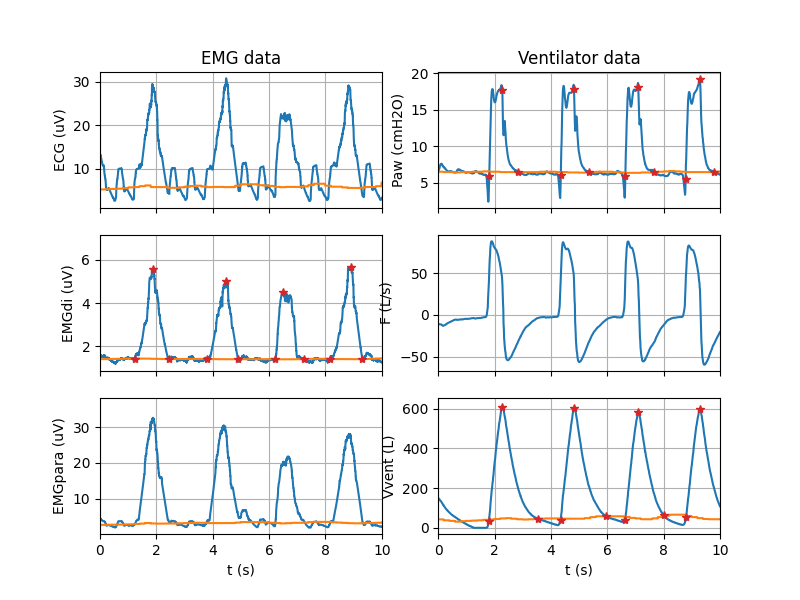

In [19]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(8, 6), sharex=True)
axes_emg = axis[:, 0]
emg_timeseries.run('plot_full', axes=axes_emg, signal_type='env')
emg_di.plot_markers(peak_set_name='breaths', axes=axes_emg[1])

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# Ventilator data data
axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)
p_vent.plot_markers(peak_set_name='ventilator_breaths', axes=axes_vent[0])
v_vent.plot_markers(peak_set_name='ventilator_breaths', axes=axes_vent[2])
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')
axes_vent[-1].set_xlim([0, x_lim])

In [22]:
# Calculate ETPdi
emg_di.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')

print(emg_di.peaks['breaths'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi
0      3885       2532     4951   True  0.347842   1.192236  2.343716
1      9151       7962    10002   True  0.273819   1.192236  2.042022
2     13292      12755    14367   True  0.182433   1.240335  1.790498
3     18245      16789    19040   True  0.273081   1.240335  2.297367


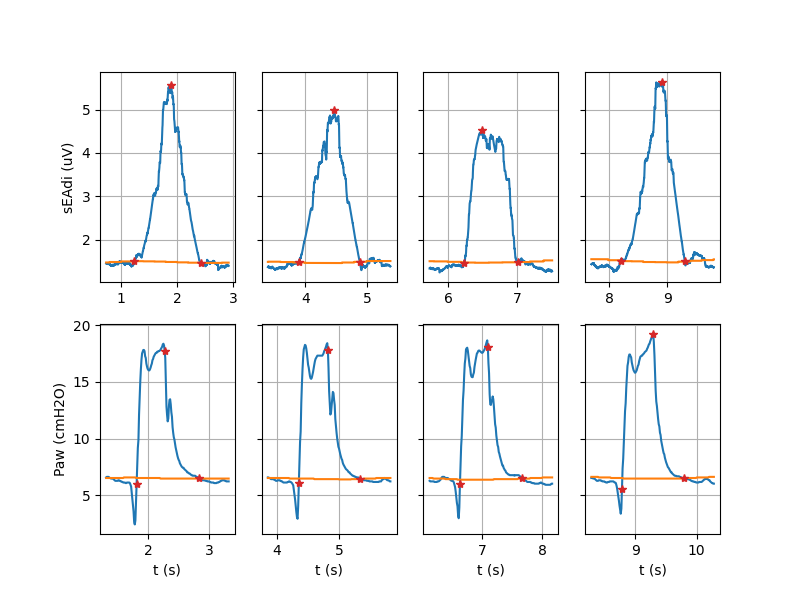

In [23]:
# Plot the individual peaks
n_peaks = len(emg_di.peaks['breaths'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(8, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='breaths')
    
emg_di.plot_markers(axes=axes_emg, peak_set_name='breaths')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='ventilator_breaths')
p_vent.plot_markers(axes=axes_vent, peak_set_name='ventilator_breaths')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

# 6. Test Pocc and sEMG quality of the peaks

In [24]:
# Test EMG quality
parameter_names = {
    'time_product': 'ETPdi'
}
emg_di.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)

# The peak-validity is updated in the peak_df:
print(emg_di.peaks['breaths'].quality_values_df)
print(emg_di.peaks['breaths'].quality_outcomes_df)

   peak_idx       snr        aub  aub_y_refs       bell
0      3885  3.753466  14.841468    1.192236   8.457070
1      9151  3.366646  13.409200    1.192236   6.093675
2     13292  3.043402  10.188971    1.240335  14.516667
3     18245  3.753713  11.886693    1.240335   9.993597
   peak_idx  baseline_detection  interpeak_distance   snr   aub  bell  \
0      3885                True                True  True  True  True   
1      9151                True                True  True  True  True   
2     13292                True                True  True  True  True   
3     18245                True                True  True  True  True   

   relative_aub  relative_etp  
0          True          True  
1          True          True  
2          True          True  
3          True          True  


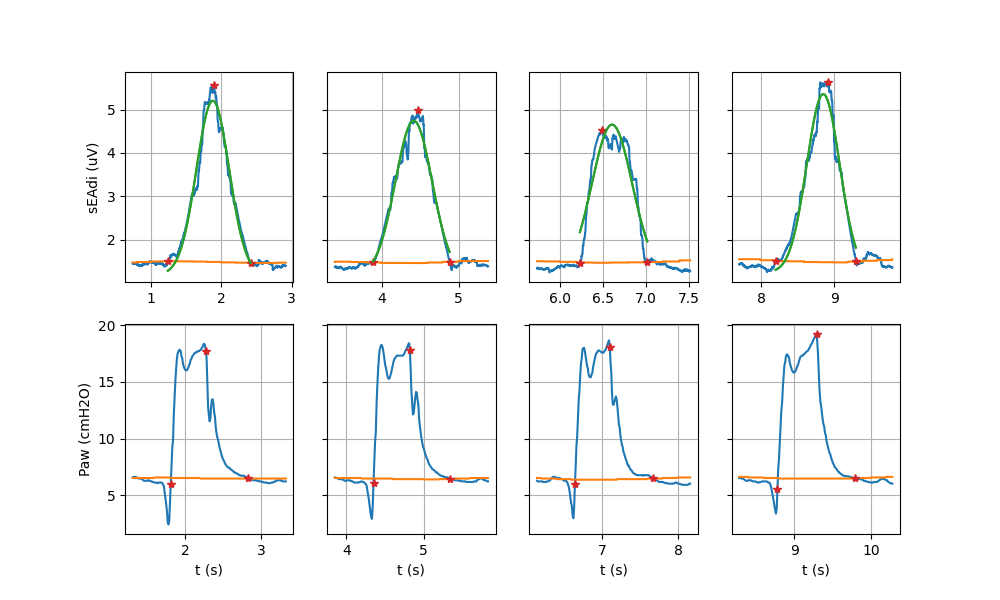

In [29]:
# Plot the individual peaks bell-fit
n_peaks = len(emg_di.peaks['breaths'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='breaths')
emg_di.plot_markers(axes=axes_emg, peak_set_name='breaths')
emg_di.plot_curve_fits(axes=axes_emg, peak_set_name='breaths')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='ventilator_breaths')
p_vent.plot_markers(axes=axes_vent, peak_set_name='ventilator_breaths')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

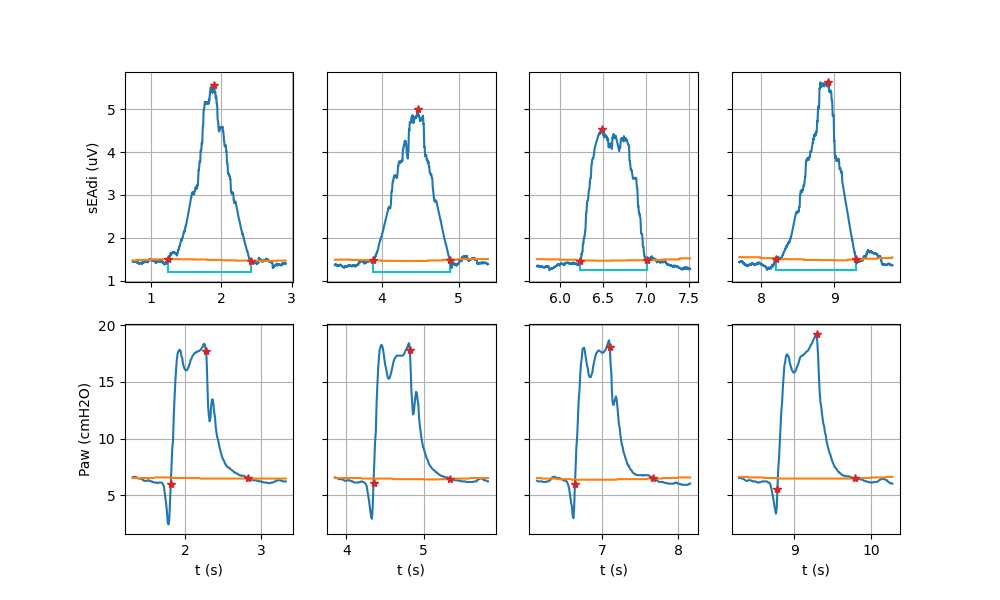

In [30]:
# Plot the individual peaks bell-fit
n_peaks = len(emg_di.peaks['breaths'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
emg_di.plot_aub(axes=axes_emg, signal_type='env', peak_set_name='breaths')
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='breaths')
emg_di.plot_markers(axes=axes_emg, peak_set_name='breaths')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='ventilator_breaths')
p_vent.plot_markers(axes=axes_vent, peak_set_name='ventilator_breaths')

for axis in axes_vent:
    axis.set_xlabel('t (s)')